# Implementation notes:
1. Global variables: Some variables previously needed to be defined globally. None do for now, but it might be cleaner if they were. Ex. all of the material properties and layer geometry
2. Numpy arrays: B and rho inputs **must be numpy arrays** because normal python array multiplication is dumb (or maybe Jes is)
3. I might be confused about the $SH_j$ part of the calculation. They define the radiation pattern, so I think they use source layer parameters.
4. The $\eta_\beta$ is taken as the slowness of the source layer. Maybe it's supposed to be the slowness of the layer the ray is in at each point but ~~ugh no~~ I hope not.

# Modeling the Alum Rock M4.6 Event

The original velocity structure used with the GRT code was

    3    2 1500    0.25000001E-01
       6
   0.100000E-02   0.100000E-02   0.100000E-02   0.100000E-02   0.000000E+00
   0.550000E+01   0.220300E+01   0.240000E+01   0.450000E+01   0.000000E+00
   0.630000E+01   0.334000E+01   0.267000E+01   0.350000E+01   0.000000E+00
   0.630100E+01   0.334100E+01   0.267000E+01   0.800000E+01   0.000000E+00
   0.670000E+01   0.397000E+01   0.280000E+01   0.190000E+02   0.000000E+00
   0.780000E+01   0.400000E+01   0.330000E+01   0.400000E+03   0.000000E+00

Where:

line 1:  layer-above-source    fluid(0)-or-solid(2)    number-of-time-points   time-sample-rate
line 2:  number-of-layers
line 3+ p-velocity(km/s)  s-velocity(km/s)  density(g/cc)  thickness(km)  layer-dip(radians)

We'll use the same simple velocity model:
* Layer 1: d = 5km, B = 2.2km/s, rho = 2.4 g/cc
* Layer 2: d = 16km, B = 3.34km/s, rho = 2.67 g/cc
* Layer 3: d = 35km, B = 3.97km/s, rho = 2.8 g/cc
* Source depth: d = 8km

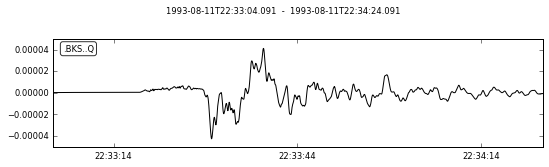

In [2]:
import matplotlib.pyplot as plt
import obspy
d=obspy.read('alumdata')
d.plot()

## Define ray functions
t_[**u**p or **d**own][**T**ransmit or **R**eflect at each layer until station]

In [3]:
def t_uT(p1,x,zs,B):
    return p1*x + (z[0]-z[1])*np.sqrt(1/B[1]**2-p1**2) + z[1]*np.sqrt(1/B[0]**2-p1**2)
def t_uTRR(p1,x,zs,B):
    return p1*x + (z[0]-z[1])*np.sqrt(1/B[1]**2-p1**2) + 3*z[1]*np.sqrt(1/B[0]**2-p1**2)
def t_uTRRRR(p1,x,zs,B):
    return p1*x + (z[0]-z[1])*np.sqrt(1/B[1]**2-p1**2) + 5*z[1]*np.sqrt(1/B[0]**2-p1**2)
def t_dRT(p1,x,zs,B):
    return p1*x + (2*z[2]-z[0]-z[1])*np.sqrt(1/B[1]**2-p1**2) + z[1]*np.sqrt(1/B[0]**2-p1**2)
def t_dTRTT(p1,x,zs,B):
    return p1*x + 2*(z[3]-z[2])*np.sqrt(1/B[2]**2-p1**2) + 2*(z[2]-z[1])*np.sqrt(1/B[1]**2-p1**2) + z[1]*np.sqrt(1/B[0]**2-p1**2)


## Define p-finding function

In [4]:
def t_from_p(x, zs, B, tfunc, tmax):
    p = [0*1j]
    t = [tfunc(p[0],x,zs,B).real]
    
    while t[-1] < tmax:
        w0 = p[-1].real
        y0 = p[-1].imag
        coords = []
        for theta in range(0,90):
            th = theta*math.pi/180
            w = w0 + np.cos(th)*.0005
            y = y0 + np.sin(th)*.0005
            coords.append((w,y))
        tvals = [tfunc(complex(*coord),x,zs,B) for coord in coords]
        t_ind = np.argmax([tv.real for tv in tvals])
        t.append(tvals[t_ind].real)
        p.append(complex(*coords[t_ind]))
    
    return t, np.array(p)

## Condense dp/dt interpolation

In [5]:
def interp_p(t,p):
    dt = .01
    f=interp1d(t,p)
    xi=np.arange(t[0],t[-1],dt)
    yi = f(xi)
    return yi,np.diff(yi)/dt

## Define ray-processing functions
Output ${\rm Im}\left (\frac{\sqrt p}{\eta} SH_j(p) \Pi(p) p \frac{dp}{dt}\right )$, where $SH_j$ are the radiation patterns and $\Pi$ is the product of reflection and transmission coefficients, for each ray. Note that SH1 and SH2 are equivalent to tds and tss in EPS 207.

In [6]:
def i_uT(t,p,B,rh):
    yi,dpdt = get_dpdt(t,p) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(yi[:-1])*Tr*dpdt/B[1]**2)
    return SH1,SH2

## Calculate Synthetic seismogram with radiation pattern and source time function (Helmberger Eqn2.33)
The SH solution on a free boundary is defined as $V = \frac{M_0}{4\pi\rho_0}\frac{d}{dt}[\dot{D(t)} * \Sigma^{2}_{j=1} A_{j+3}(\theta,\lambda,\delta)V_i(t)]$, where $V_i(t) = \sqrt{2/r}\frac{1}{\pi}[\frac{1}{\sqrt{t}}*SH_j]$. $M_0$ is the scalar seismic moment (units of dyne-cm...default is $10^{20}$ dyne-cm); $\dot{D(t)}$ is the source time function (e.g., triangle; Brune); $A_{j+3}(\theta,\lambda,\delta)$ are the coefficients describing the relative weight of the transverse vertical strike-slip (tss) and dip-slip (tds) fundamental-faults, which depend on fauilt dip ($\delta$), rake ($\lambda$), and angle between station and strike of fault ($\theta$).

In [24]:
def Vt_SH1(t,r,SH1):    
    return np.sqrt(2/r)/np.pi*((1/np.sqrt(t))*(SH1))

def Vt_SH2(t,r,SH2):    
    return np.sqrt(2/r)/np.pi*((1/np.sqrt(t))*(SH2))

def radiationPattern(azimuth,strike,dip,rake,moment):
    theta=azimuth-strike;
    theta=theta*pi/180;
    rake=rake*pi/180;
    dip=dip*pi/180;
    moment=moment/1e20;
    factor=4*pi*rho;
    A4=cos(2*theta)*cos(rake)*sin(dip)-0.5*sin(2*theta)*sin(rake)*sin(2*dip);
    A5=-1*sin(theta)*cos(rake)*cos(dip)-cos(theta)*sin(rake)*cos(2*dip);
    return A4,A5

def synth_sourcetime(A4,A5,M0,Vt_SH1,Vt_SH2,risetime,dt):
    def synth(A4,A5,M0,Vt_SH1,Vt_SH2):
        s = np.diff((A4*Vt_SH1 + A4*Vt_SH1))
        return M0/(4*np.pi*rh)*s
    def makeDdot(risetime,dt):
        time=np.arange(0,risetime*3,dt)
        sourceTimeFn=time*e**(-time/(risetime/4))
        return sourceTimeFn/trapz(sourceTimeFn)
    return np.convolve(D_dot,synth)

#### Compute synthetic for Alum Rock

In [26]:
#put alum rock geometry and velocity and rho in here.
#
#
# then this part
azimuth=321.6;
strike=318;
dip=83;
rake=-176;
M0=9.20e22;
risetime=1;
tstart=20;
nzyear=1993;
nzjday=223;
nzhour=22;
nzmin=33;
nzsec=4;
nzmsec=100;

In [27]:
#..calculate up to SH1 and SH2
SH1,SH2 = i_uT(t,p,B,rh)
A4,A5 = radiationPattern(azimuth,strike,dip,rake,M0)
uSH = synth_sourcetime(A4,A5,M0,Vt_SH1,Vt_SH2,risetime,dt)

NameError: name 't' is not defined

In [13]:
import numpy as np
from scipy.interpolate import interp1d